# Environment Setup

In [1]:
!pip install gpytoolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 15.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 31.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 39.4 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.16.2
    Uninstalling imageio-2.16.2:
      Successfully uninstalled imageio-2.16.2


In [1]:
import gpytoolbox as gpy
import numpy as np
import matplotlib.pyplot as plt
import utils
import torch
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

Using device: cuda


# Dataset

## Random Sample

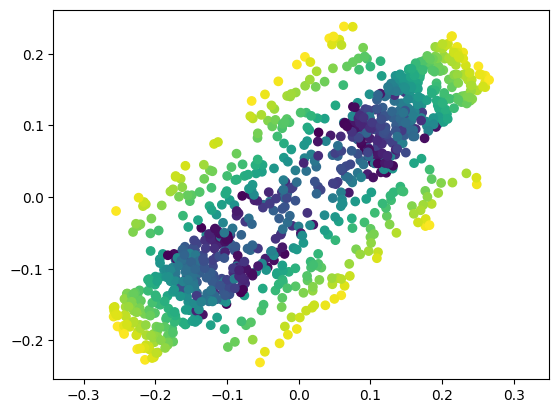

In [2]:
random_pts, normals = utils.generate_random_rectangle(1000)
X_coords, Y = utils.generate_pts_from_normals(random_pts, normals)
_ = plt.scatter(X_coords[:,0], X_coords[:,1], c=Y)
_ = plt.axis('equal')

## Generating dataset

100%|█████████████████████████████████| 100000/100000 [00:27<00:00, 3661.36it/s]


(-0.46436288952827454,
 0.46404168009757996,
 -0.29915727227926253,
 0.29976777285337447)

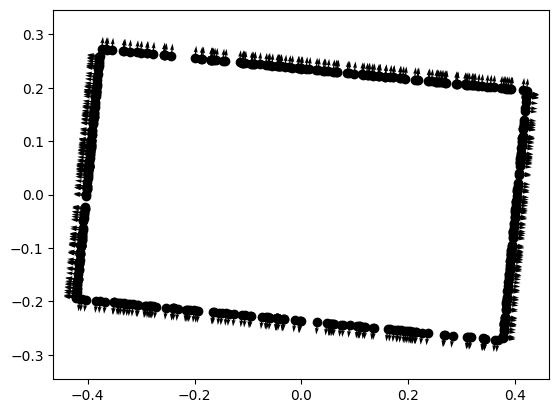

In [3]:
n_samples = 10**5
dataset = utils.RectData(num_samples=n_samples, size=500, num_seed=None)

# Visualize data samples
grid, normals = dataset[0]
plt.scatter(grid[:,0],grid[:,1],c="k")
plt.quiver(grid[:,0],grid[:,1],normals[:,0],normals[:,1],color="k")
plt.axis('equal')

100%|█████████████████████████████████| 100000/100000 [00:27<00:00, 3686.80it/s]


(-0.44961552023887635,
 0.4496449649333954,
 -0.2566938206553459,
 0.2564799293875694)

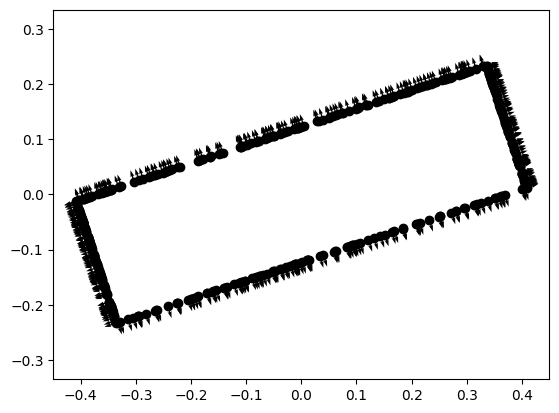

In [4]:
n_samples = 10**5
test_dataset = utils.RectData(num_samples=n_samples, size=500, num_seed=None)

# Visualize data samples
grid, normals = test_dataset[0]
plt.scatter(grid[:,0],grid[:,1],c="k")
plt.quiver(grid[:,0],grid[:,1],normals[:,0],normals[:,1],color="k")
plt.axis('equal')

## Utils

In [5]:
def plot_neural_process(xs, ys, mu, std, X,y, grid_size, plot_sample=0):
    """
    Plot Mean and Std of Neural Process side by side.

    Parameters:
    - xs: x grid values
    - ys: y grid values
    - mu: mean tensor values
    - std: standard deviation tensor values
    - X: scatter plot data
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    X = X.cpu()
    y = y.cpu().numpy()
    print(X.shape)
    # Mean of Neural Process plot
    axes[0].set_title("Mean of Neural Process")
    c1 = axes[0].pcolormesh(xs, ys, mu.cpu().view((grid_size,grid_size)).detach().numpy(), shading='gouraud', cmap="viridis")
    fig.colorbar(c1, ax=axes[0])
    axes[0].contour(xs, ys, mu.cpu().view((grid_size,grid_size)).detach().numpy(), levels=[0], colors='black')
    axes[0].scatter(X[0][:,0].numpy(), X[0][:,1].numpy(), c=y, cmap="viridis")

    # Std of Neural Process plot
    axes[1].set_title("Std of Neural Process")
    c2 = axes[1].pcolormesh(xs, ys, std.cpu().view((grid_size,grid_size)).detach().numpy(), shading='gouraud', cmap="plasma")
    fig.colorbar(c2, ax=axes[1])
    axes[1].scatter(X[0][:,0].numpy(), X[0][:,1].numpy(), c=y, cmap="viridis")
    
    plt.tight_layout()
    plt.show()

    if plot_sample > 0:
        m = torch.distributions.normal.Normal(mu, std)
        for i in range(plot_sample):
            sample = m.rsample().detach()

            plt.title("Sample of Neural Process")
            plt.pcolormesh(xs,ys,sample.cpu().reshape((grid_size,grid_size)).detach().numpy(),shading='gouraud',cmap="plasma")
            plt.colorbar()
            plt.contour(xs,ys,sample.cpu().reshape((grid_size,grid_size)).detach().numpy(),levels=[0], colors='black')
            plt.scatter(X[0][:,0].numpy(), X[0][:,1].numpy(), c=y, cmap="viridis")
            plt.tight_layout()
            plt.show()

In [6]:
def get_context_and_target(x, normals, n_context, n_target):
    # Ensure n_context is less than or equal to n_target
    assert n_context <= n_target, "n_context should be less than or equal to n_target"

    batch_size = x.size(0)
    
    x_context_list, y_context_list, x_target_list, y_target_list = [], [], [], []
    
    for b in range(batch_size):
        # Sample n_target indices from the range [0, x.size(1)-1]
        target_indices = torch.randperm(x.size(1))[:n_target]

        # Get x_target and y_target values for the batch
        x_target_b = x[b, target_indices]
        normals_target_b = normals[b, target_indices]

        # From the n_target indices, subsample n_context indices
        context_indices = torch.randperm(n_target)[:n_context]

        # Get x_context and y_context values for the batch
        #print(context_indices.shape, context_indices)
        #print(x_target_b.shape, y_target_b.shape)
        x_context_b = x_target_b[context_indices]
        normals_context_b = normals_target_b[context_indices]

        x_context_b, y_context_b = utils.data.generate_pts_from_normals(x_context_b.cpu().numpy(), normals_context_b.cpu().numpy(), n_points=x_context_b.shape[0]*2)
        x_context_b, y_context_b = torch.tensor(x_context_b, dtype=torch.float32), torch.tensor(y_context_b,dtype=torch.float32)

        x_target_b, y_target_b = utils.data.generate_pts_from_normals(x_target_b.cpu().numpy(), normals_target_b.cpu().numpy(), n_points=x_target_b.shape[0]*2)
        x_target_b, y_target_b = torch.tensor(x_target_b, dtype=torch.float32), torch.tensor(y_target_b,dtype=torch.float32)
        
        x_context_list.append(x_context_b)
        y_context_list.append(y_context_b)
        x_target_list.append(x_target_b)
        y_target_list.append(y_target_b)
    
    x_context = torch.stack(x_context_list)
    y_context = torch.stack(y_context_list)
    x_target = torch.stack(x_target_list)
    y_target = torch.stack(y_target_list)

    return x_context, y_context, x_target, y_target

In [7]:
def test(model, dataloader, writer=None, plot=True, global_step=None, seed=42, title='', size=50, grid_size=100, use_normals=False,
        predict_twice=True):
    model.eval()
    model.to(device)
    with torch.no_grad():
        Xs, _ = next(iter(dataloader))
        context_x, context_y = Xs[0], torch.zeros(Xs[0].size(0),1)
        context_indices = torch.randperm(context_x.size(0))[:size]
        context_x = torch.Tensor(context_x[context_indices]).reshape((1,size,2)).to(device)
        context_y = torch.Tensor(context_y[context_indices]).reshape((1,size,1)).to(device)
        #print(context_x.shape, context_y.shape)
        
        # Create a set of target points corresponding to entire [-pi, pi] range
        xs = np.linspace(-1,1,grid_size)
        ys = np.linspace(-1,1,grid_size)
        Xs,Ys = np.meshgrid(xs,ys)
        Xs = Xs.flatten()
        Ys = Ys.flatten()
        grid = np.vstack((Xs,Ys)).T
        target_x = torch.Tensor(grid).reshape(1,grid_size**2,2).to(device)

        #print(context_x.shape, context_y.shape, target_x.shape)
        y_pred, kl, loss, z, y_std = model(context_x, context_y, target_x)

        # if writer is not None:
        #     writer.add_scalar('val/loss', loss, global_step=global_step)
        #     writer.add_scalar('val/y_std', y_std.mean(), global_step=global_step)
        #     writer.add_scalar('val/mse_loss', mse_loss, global_step=global_step)
        #     writer.add_scalar('val/kl', kl.mean(), global_step=global_step)

        if plot:
            plot_neural_process(xs,ys,y_pred,y_std, context_x, context_y, grid_size, plot_sample=0)
            if predict_twice:
                y_pred2, kl, loss, z, y_std = model(context_x, context_y, target_x, sample=True)
                plot_neural_process(xs,ys,y_pred2,y_std, context_x, context_y, grid_size, plot_sample=0)

            if writer is not None:
                writer.add_figure('test', global_step=global_step, close=False)
            plt.show()

    return y_pred, kl, loss, y_std

In [8]:
from tqdm import tqdm

def evaluate(model, n=100):
    return torch.stack([
        test(model)[2] for _ in tqdm(range(n))
    ]).mean().cpu()

# Attentive Neural Process

In [9]:
from src.model import LatentModel

hparams = dict(
    x_dim=2,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="dot",
    det_enc_self_attn_type="dot",
    det_enc_cross_attn_type="multihead",
    use_rnn=False)

model = LatentModel(**hparams).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

batch_size = 100
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
n_context = 100
n_target = 400
epochs = 10
PRINT_AFTER = 1000

## Training Model

In [10]:
def train(model, optim, train_dataloader, test_dataloader, epochs, n_context, n_target, plot=True):
    for epoch in range(epochs):
        epoch_loss = 0.
        with tqdm(train_dataloader, unit="batch") as tepoch:
            for data in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                model.train()

                x, normals = data
                x=x.to(device)
                normals = normals.to(device)
                #y=y.unsqueeze(-1).to(device)

                context_x, context_y, target_x, target_y = get_context_and_target(x, normals, n_context, n_target)
                #print(context_x.shape, context_y.shape, target_x.shape, target_y.shape)
                context_x = context_x.to(device)
                context_y = context_y.unsqueeze(-1).to(device)
                target_x = target_x.to(device)
                target_y = target_y.unsqueeze(-1).to(device)
                #print(context_x.shape, context_y.shape, target_x.shape, target_y.shape)
                optim.zero_grad()
                y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,target_y)
                epoch_loss += loss.item()
                loss.backward()
                optim.step()

                if (tepoch.n - 1) % PRINT_AFTER == 0:
                    _, _, _, _ = test(
                        model, test_dataloader, plot=plot, global_step=tepoch.n-1, size=n_context)
                    # print(
                    #     f"train: {tepoch.n - 1} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
                    # )
                tepoch.set_postfix(loss=loss.item())

        print("Epoch: {}, Avg_loss: {}".format(epoch, epoch_loss / len(train_dataloader)))
            

Epoch 0:   0%|                  | 1/1000 [00:00<13:57,  1.19batch/s, loss=0.496]

torch.Size([1, 100, 2])


/tmp/ipykernel_621/1526548614.py:20: UserWarning: No contour levels were found within the data range.
  axes[0].contour(xs, ys, mu.cpu().view((grid_size,grid_size)).detach().numpy(), levels=[0], colors='black')


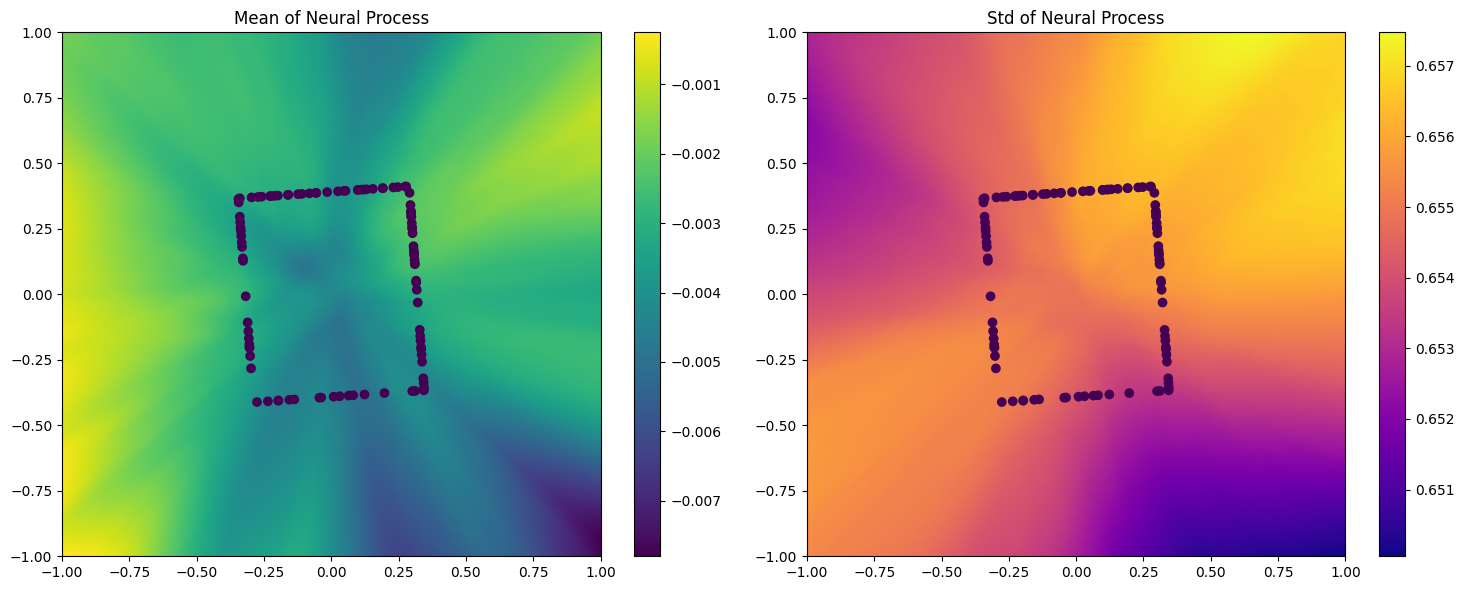

torch.Size([1, 100, 2])


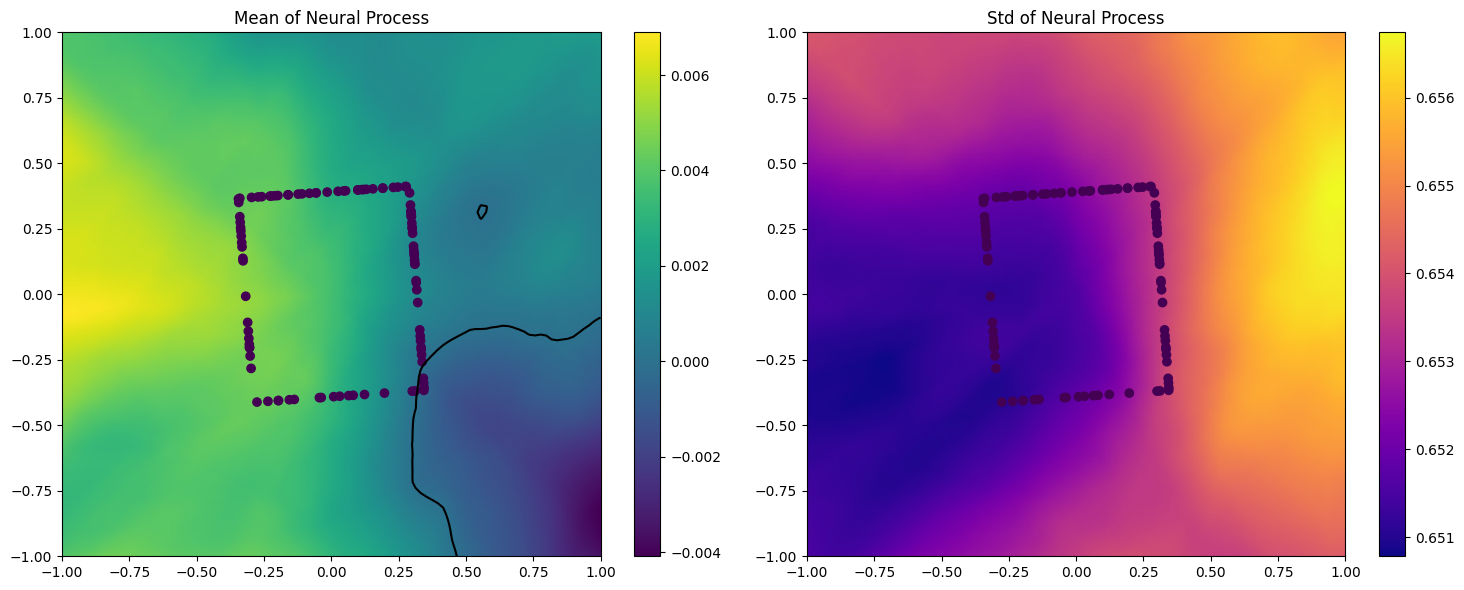

Epoch 0: 100%|███████████████| 1000/1000 [05:48<00:00,  2.87batch/s, loss=-1.72]


Epoch: 0, Avg_loss: -1.3930721346584614


Epoch 1:   0%|                  | 1/1000 [00:00<06:24,  2.60batch/s, loss=-1.71]

torch.Size([1, 100, 2])


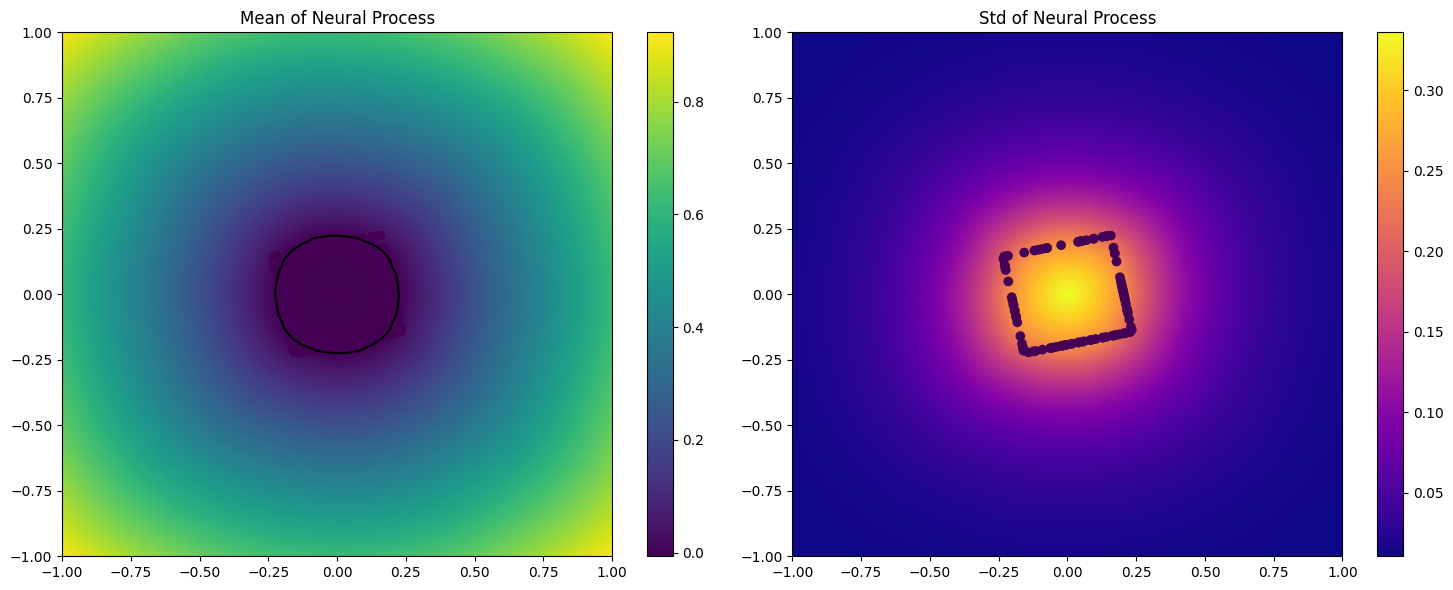

torch.Size([1, 100, 2])


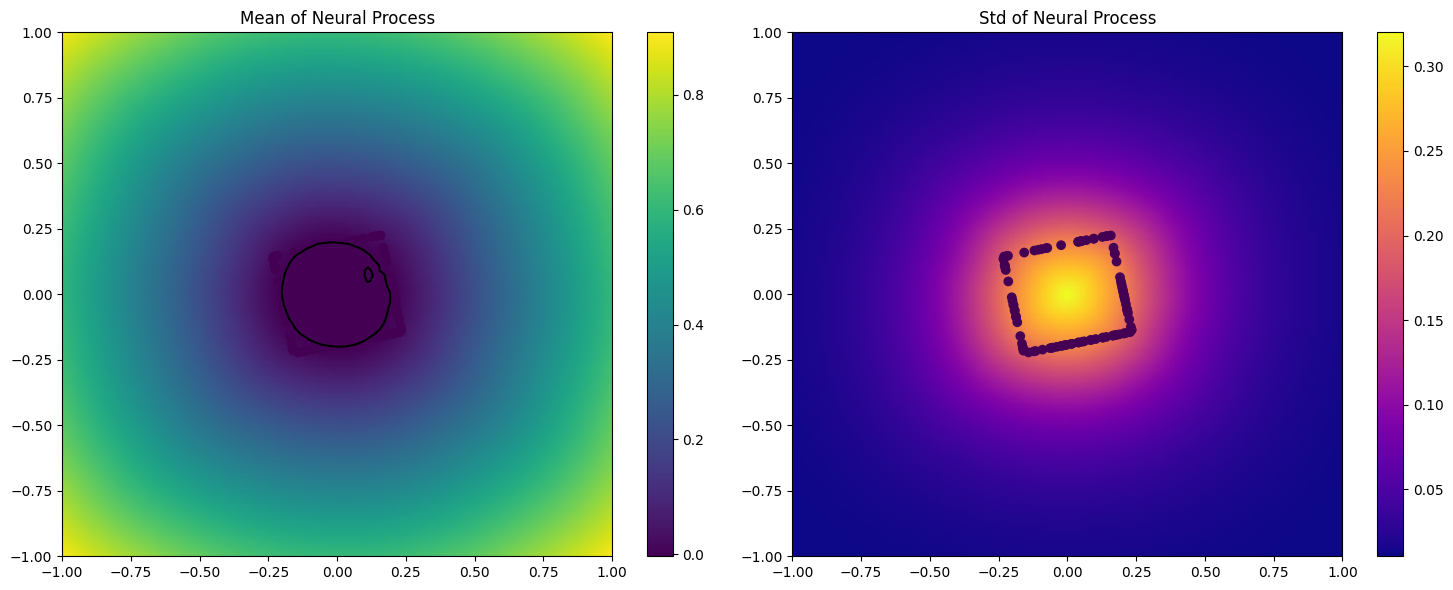

Epoch 1: 100%|███████████████| 1000/1000 [05:52<00:00,  2.84batch/s, loss=-1.77]


Epoch: 1, Avg_loss: -1.7497453913688659


Epoch 2:   0%|                  | 1/1000 [00:00<06:15,  2.66batch/s, loss=-1.78]

torch.Size([1, 100, 2])


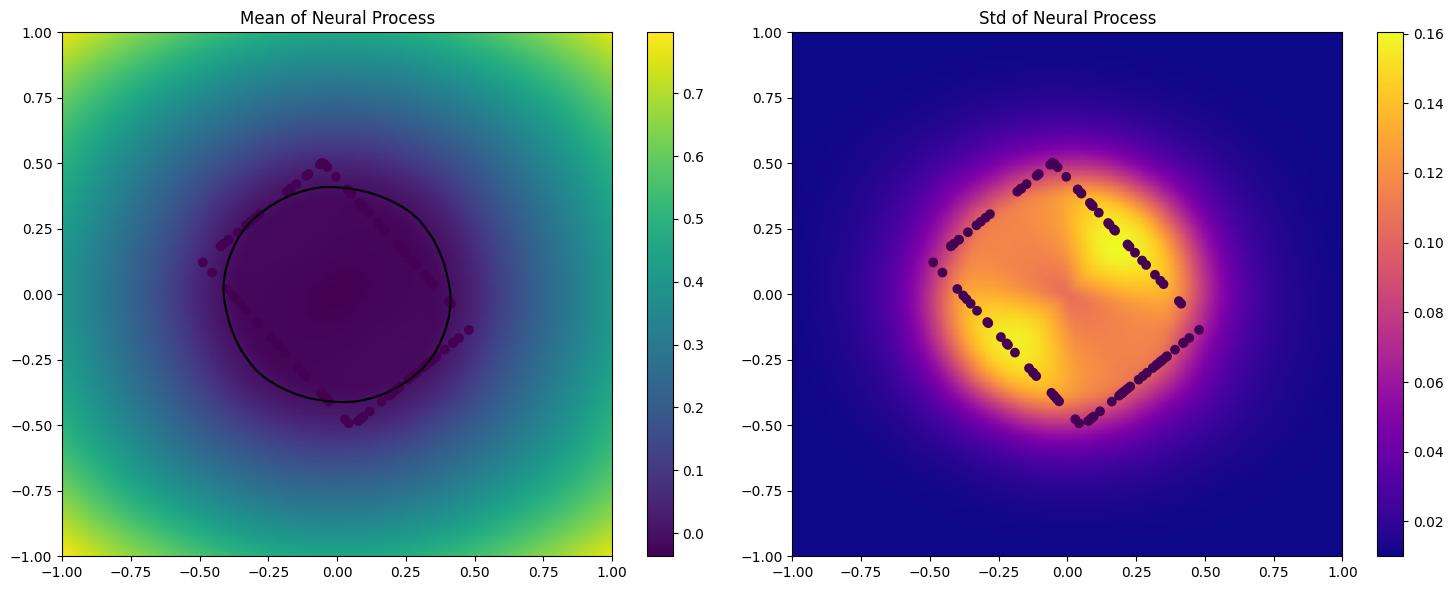

torch.Size([1, 100, 2])


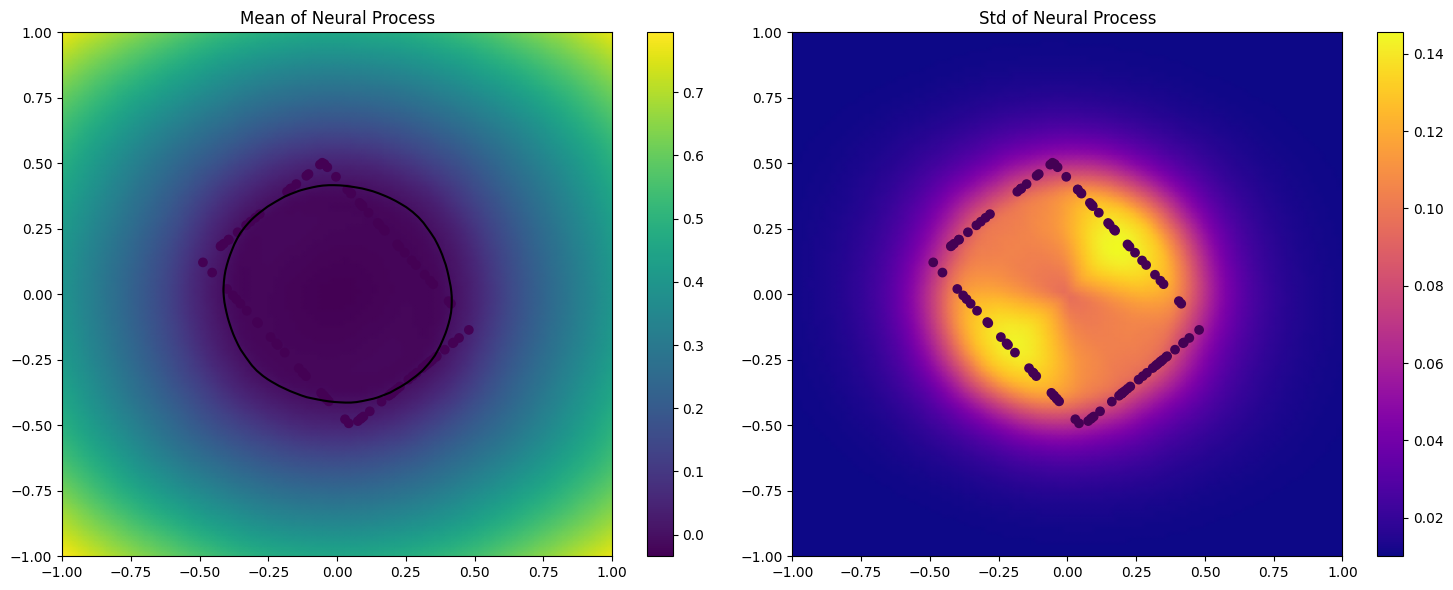

Epoch 2: 100%|███████████████| 1000/1000 [05:38<00:00,  2.96batch/s, loss=-1.86]


Epoch: 2, Avg_loss: -1.8292307294607162


Epoch 3:   0%|                  | 1/1000 [00:00<05:48,  2.86batch/s, loss=-1.91]

torch.Size([1, 100, 2])


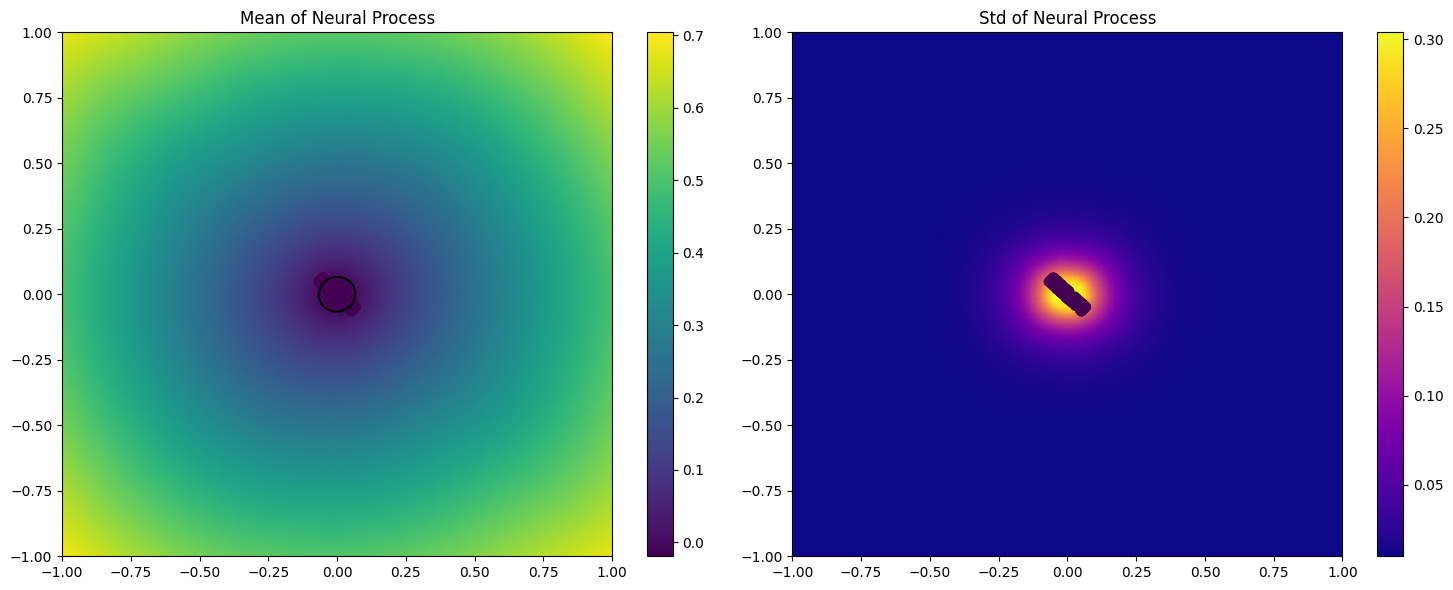

torch.Size([1, 100, 2])


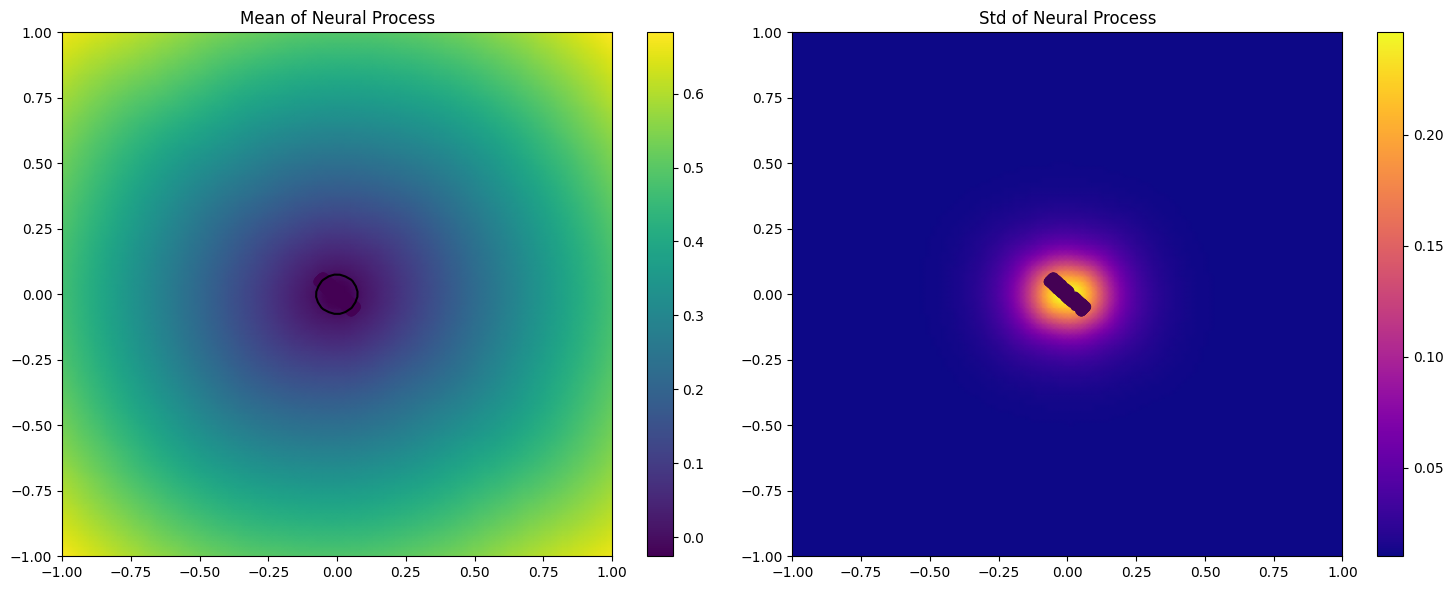

Epoch 3: 100%|████████████████| 1000/1000 [05:31<00:00,  3.01batch/s, loss=-2.1]


Epoch: 3, Avg_loss: -1.9760145847797395


Epoch 4:   0%|                  | 1/1000 [00:00<05:35,  2.98batch/s, loss=-2.11]

torch.Size([1, 100, 2])


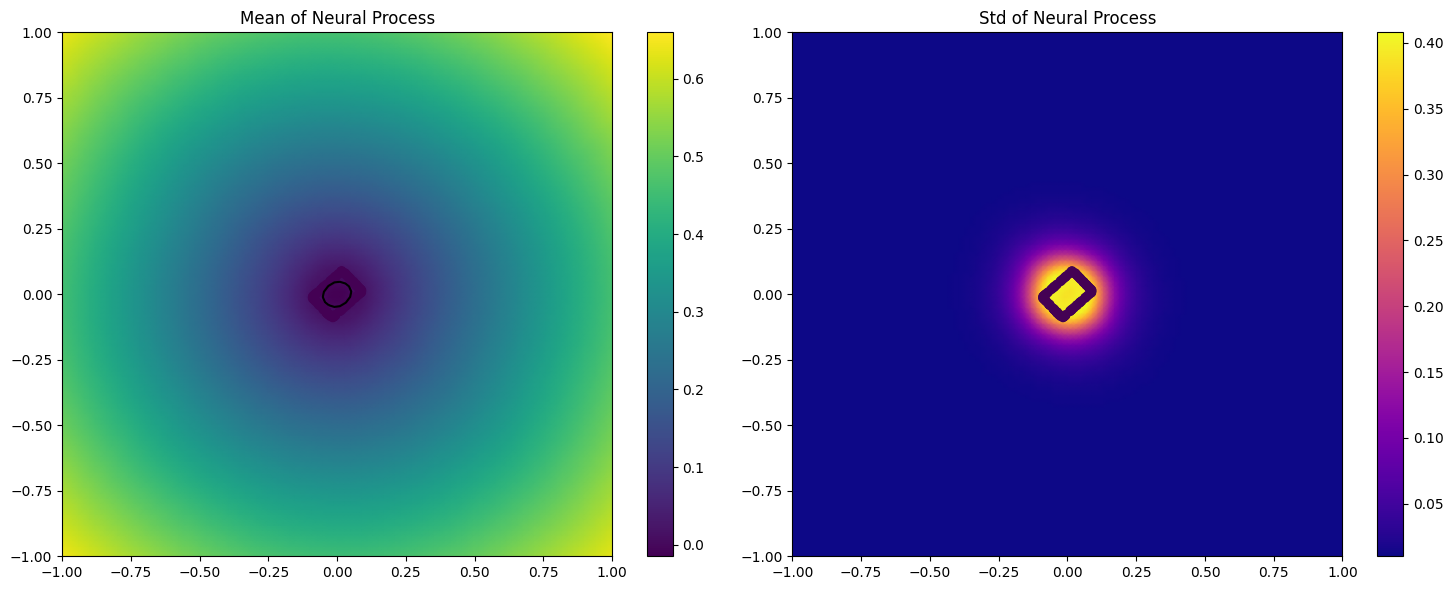

torch.Size([1, 100, 2])


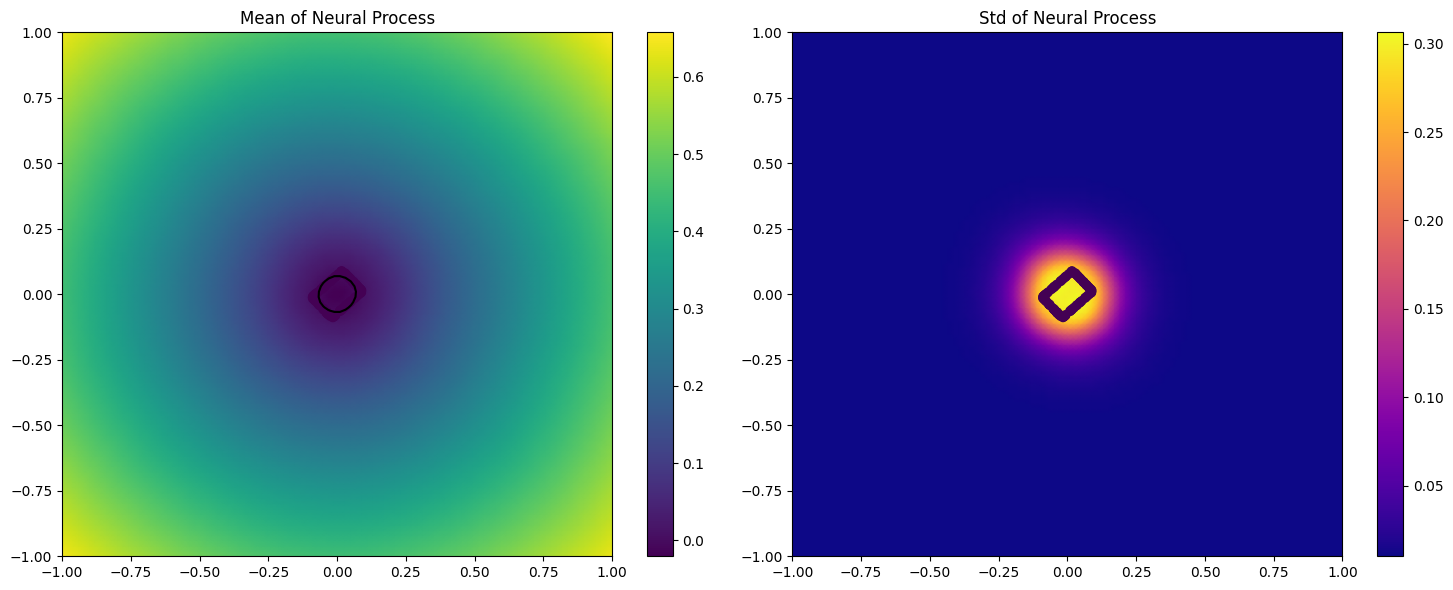

Epoch 4: 100%|███████████████| 1000/1000 [05:48<00:00,  2.87batch/s, loss=-2.49]


Epoch: 4, Avg_loss: -2.33087194108963


Epoch 5:   0%|                  | 1/1000 [00:00<06:04,  2.74batch/s, loss=-2.53]

torch.Size([1, 100, 2])


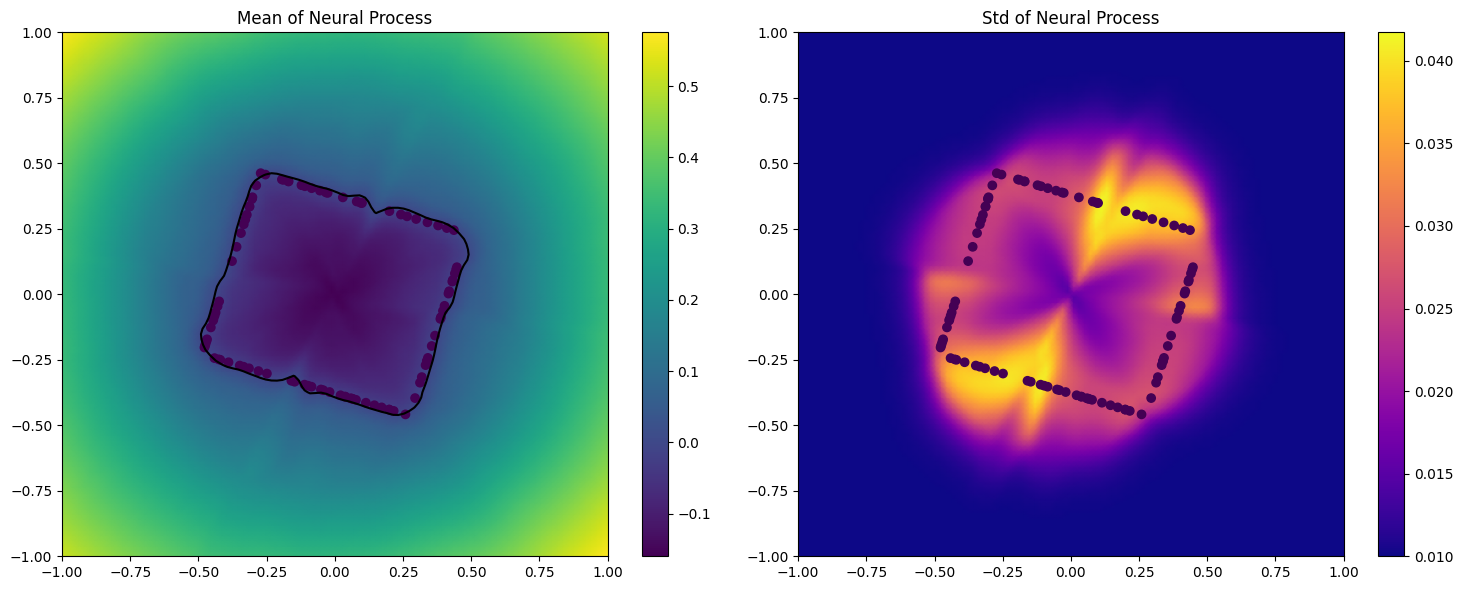

torch.Size([1, 100, 2])


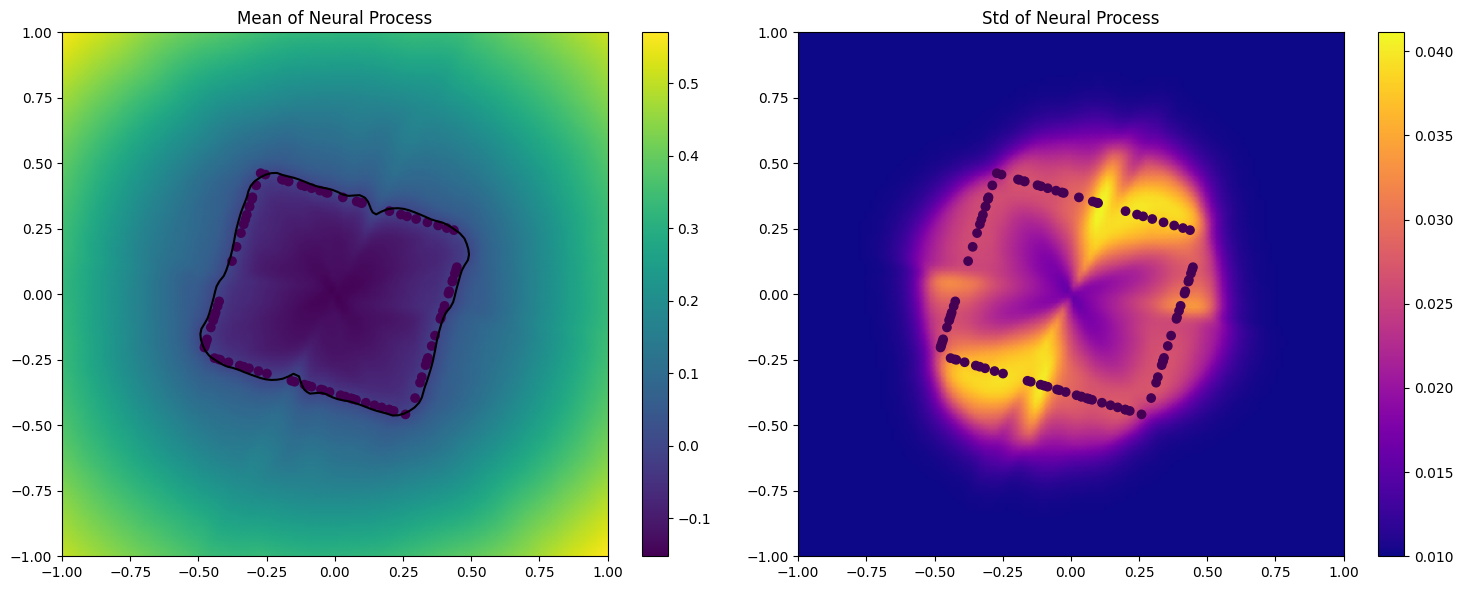

Epoch 5: 100%|███████████████| 1000/1000 [05:47<00:00,  2.88batch/s, loss=-2.73]


Epoch: 5, Avg_loss: -2.6102021226882934


Epoch 6:   0%|                  | 1/1000 [00:00<06:17,  2.64batch/s, loss=-2.69]

torch.Size([1, 100, 2])


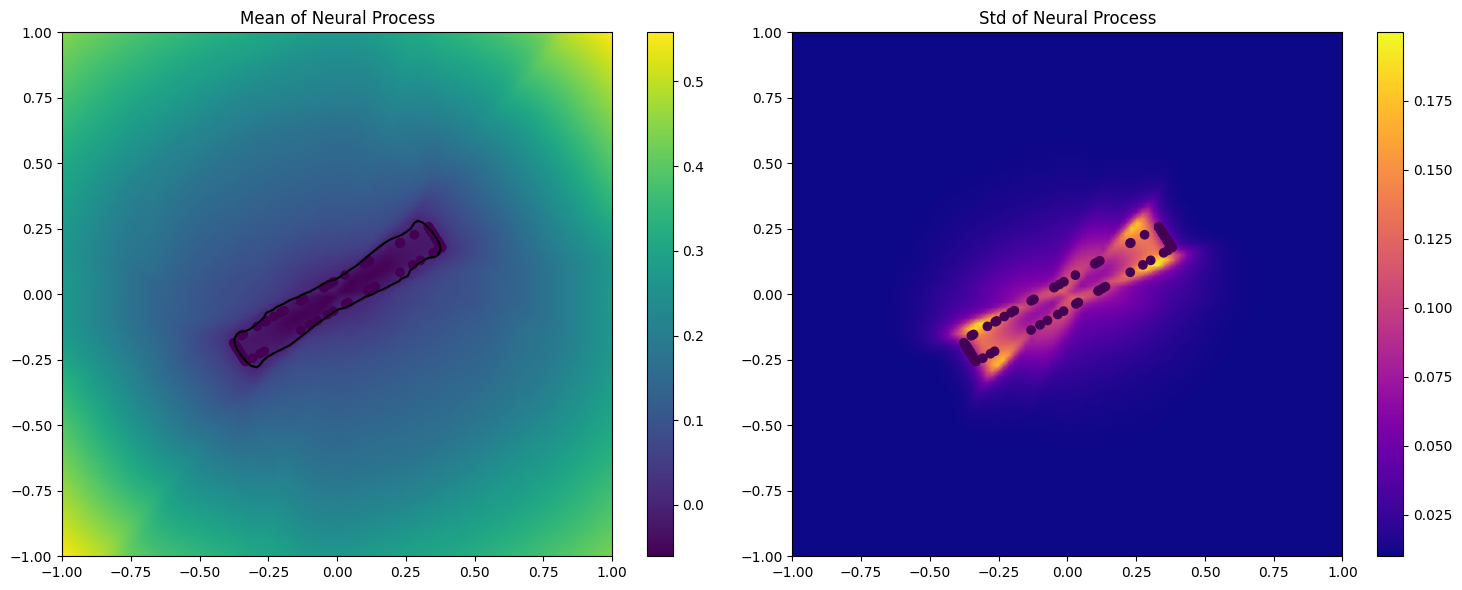

torch.Size([1, 100, 2])


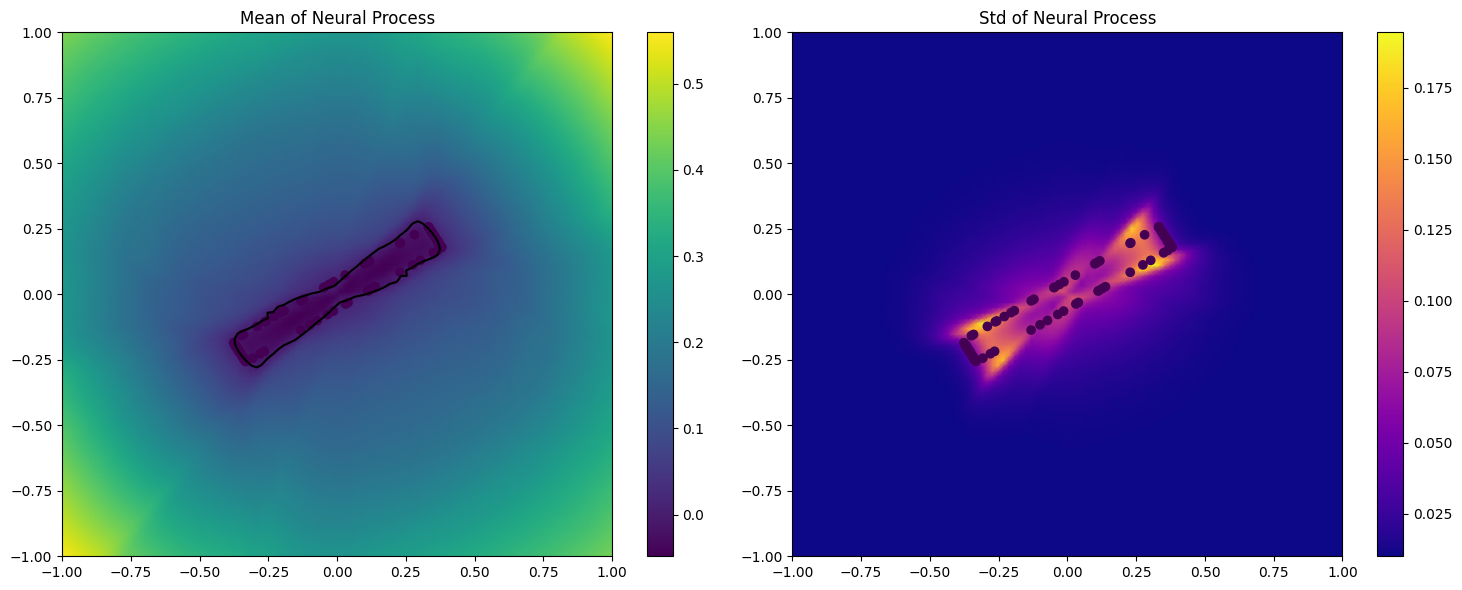

Epoch 6: 100%|███████████████| 1000/1000 [05:51<00:00,  2.84batch/s, loss=-2.81]


Epoch: 6, Avg_loss: -2.7389897775650023


Epoch 7:   0%|                  | 1/1000 [00:00<05:56,  2.80batch/s, loss=-2.78]

torch.Size([1, 100, 2])


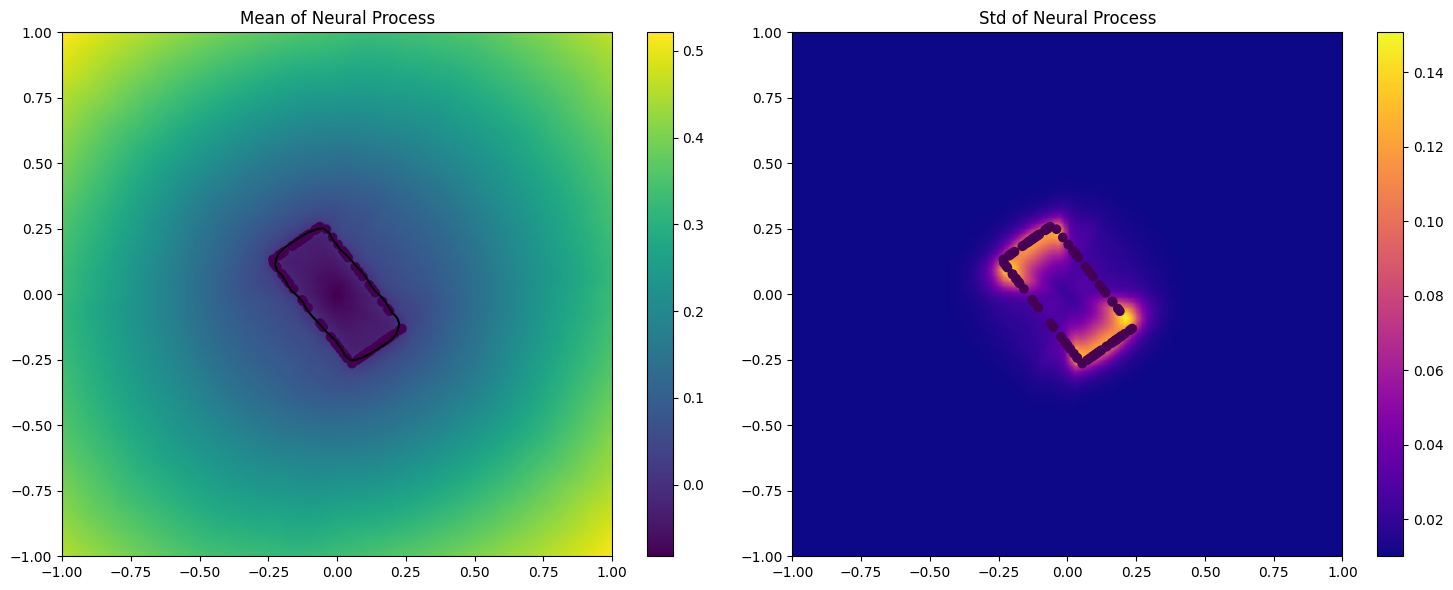

torch.Size([1, 100, 2])


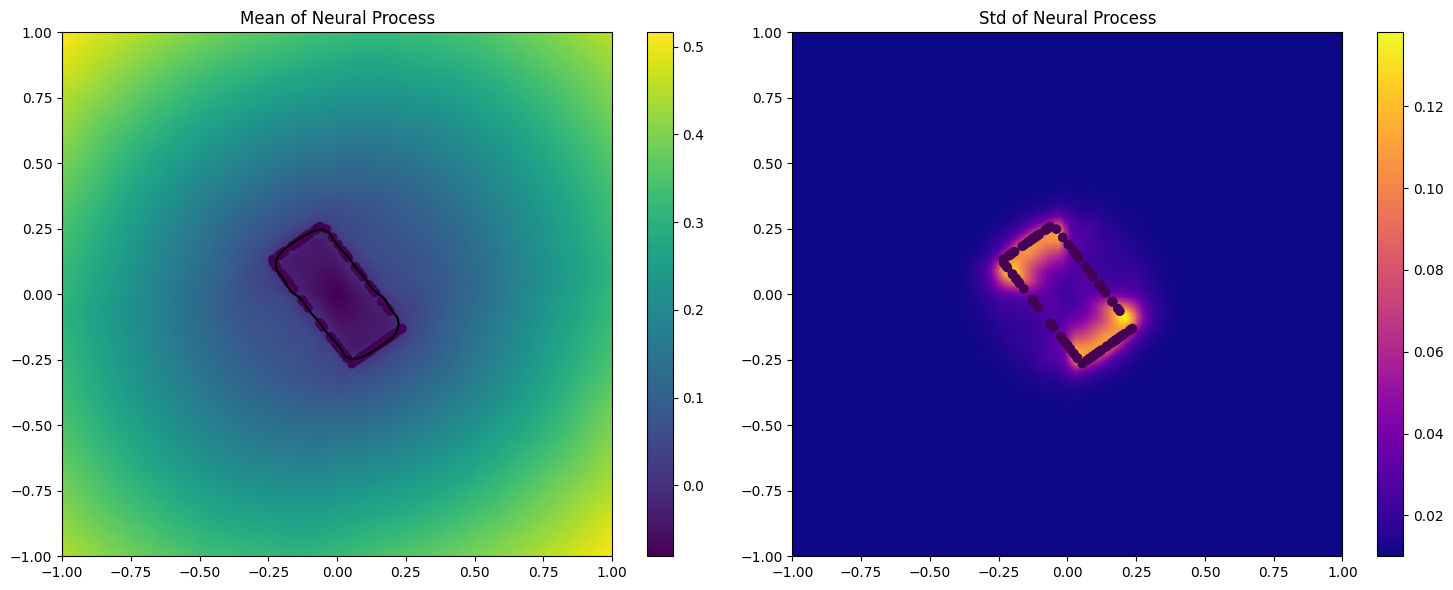

Epoch 7: 100%|███████████████| 1000/1000 [05:44<00:00,  2.90batch/s, loss=-2.82]


Epoch: 7, Avg_loss: -2.8176354048252104


Epoch 8:   0%|                   | 1/1000 [00:00<05:56,  2.80batch/s, loss=-2.7]

torch.Size([1, 100, 2])


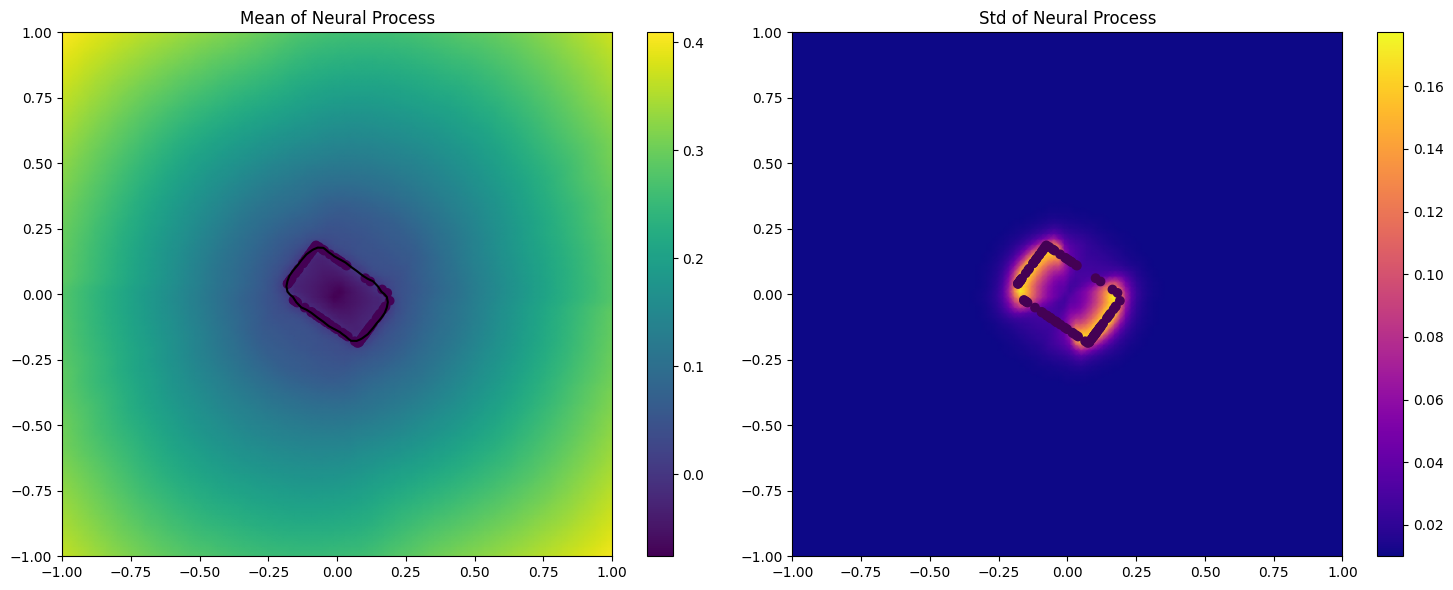

torch.Size([1, 100, 2])


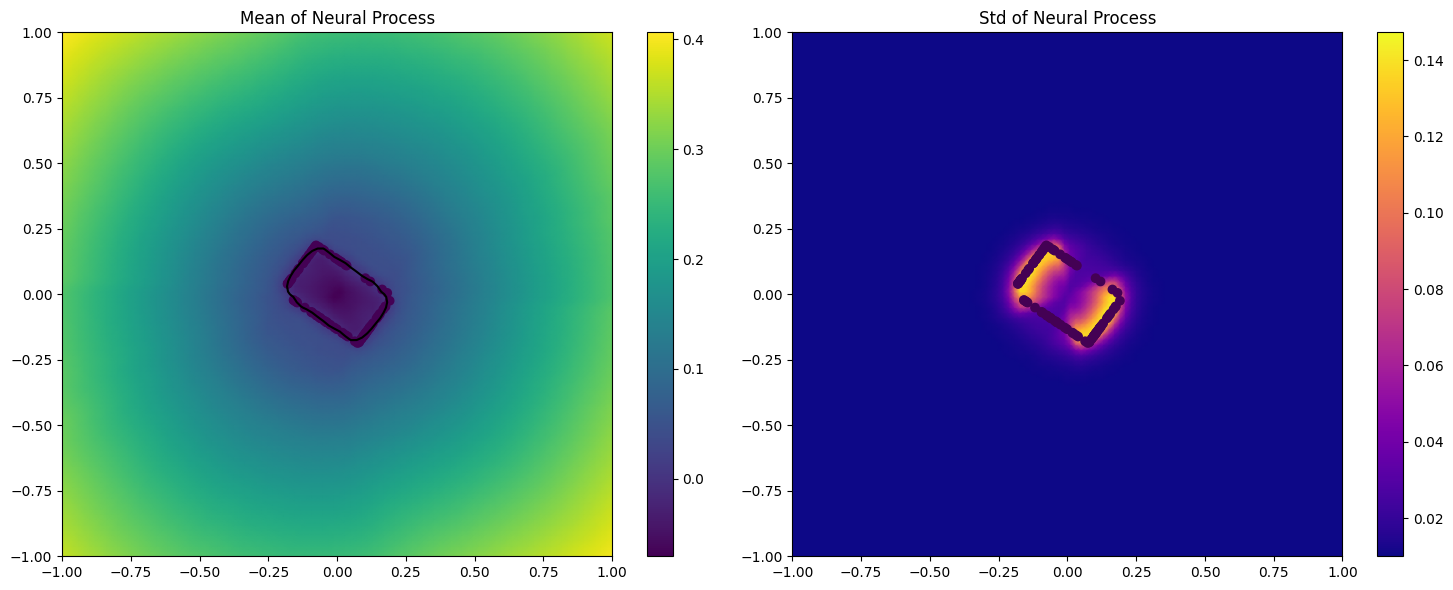

Epoch 8: 100%|███████████████| 1000/1000 [05:44<00:00,  2.90batch/s, loss=-2.88]


Epoch: 8, Avg_loss: -2.859216250896454


Epoch 9:   0%|                  | 1/1000 [00:00<05:53,  2.82batch/s, loss=-2.92]

torch.Size([1, 100, 2])


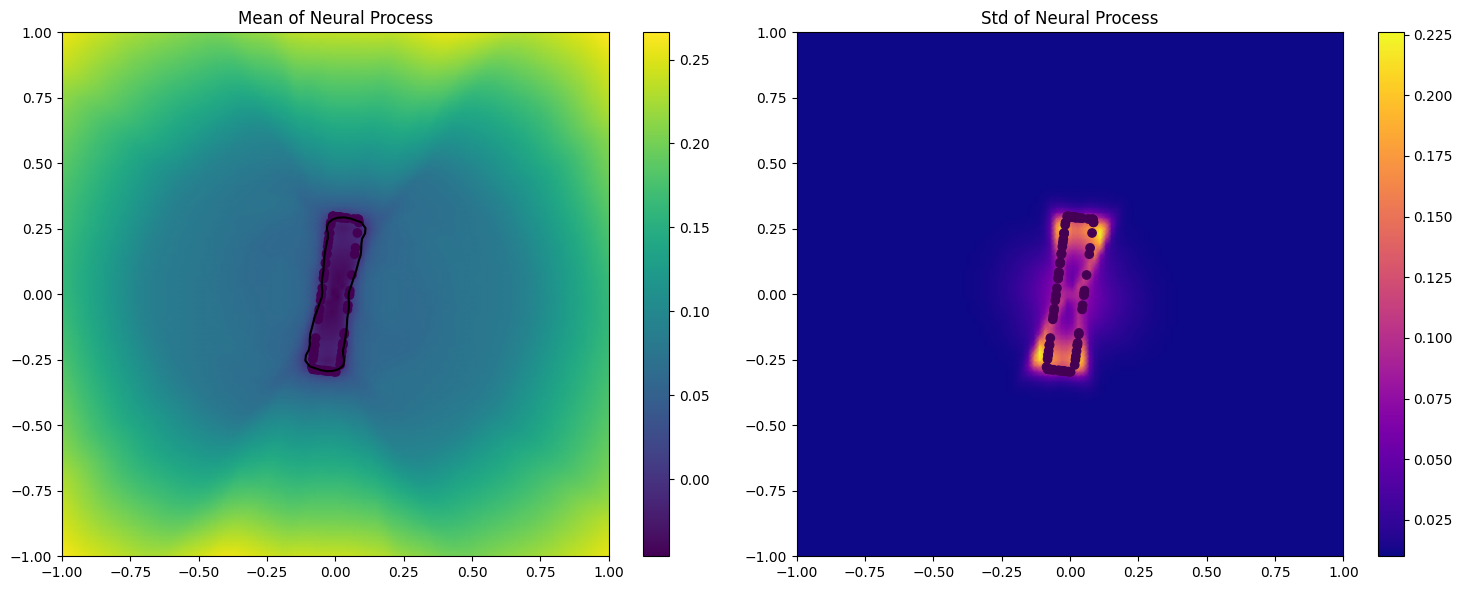

torch.Size([1, 100, 2])


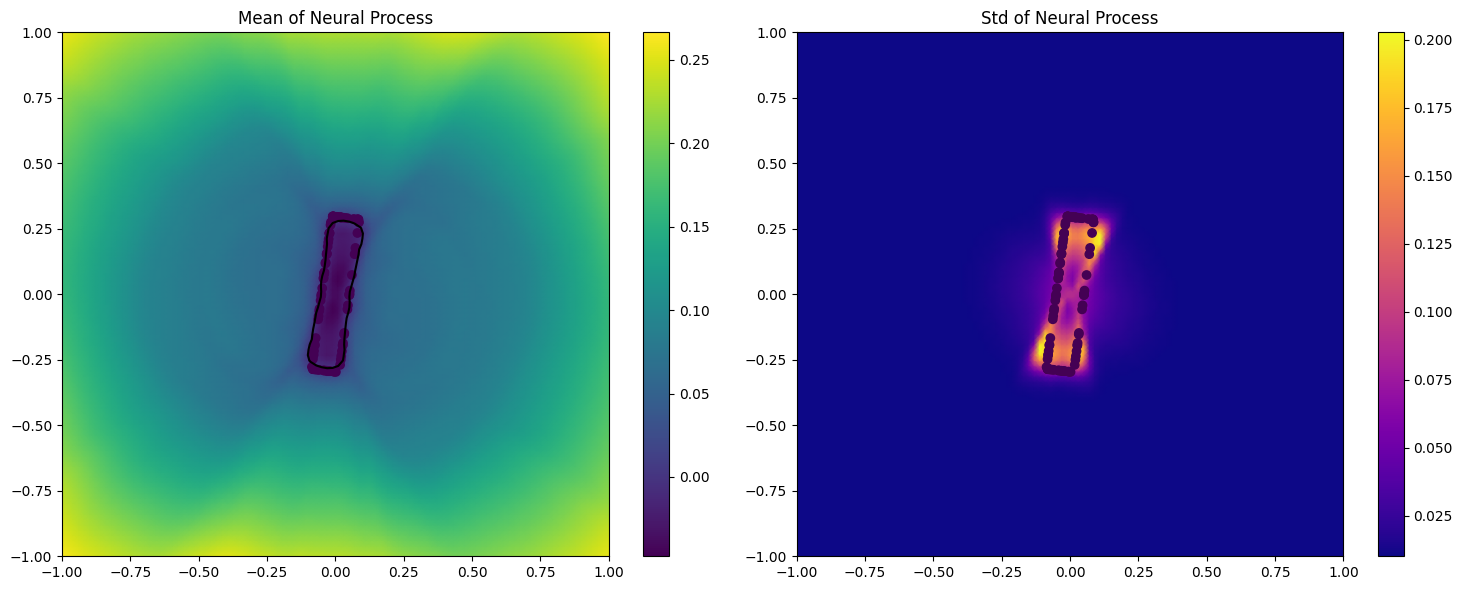

Epoch 9: 100%|███████████████| 1000/1000 [05:51<00:00,  2.84batch/s, loss=-2.93]

Epoch: 9, Avg_loss: -2.8944852068424223


In [11]:
train(model, optim, train_dataloader,test_dataloader, epochs, n_context, n_target)

torch.Size([1, 100, 2])


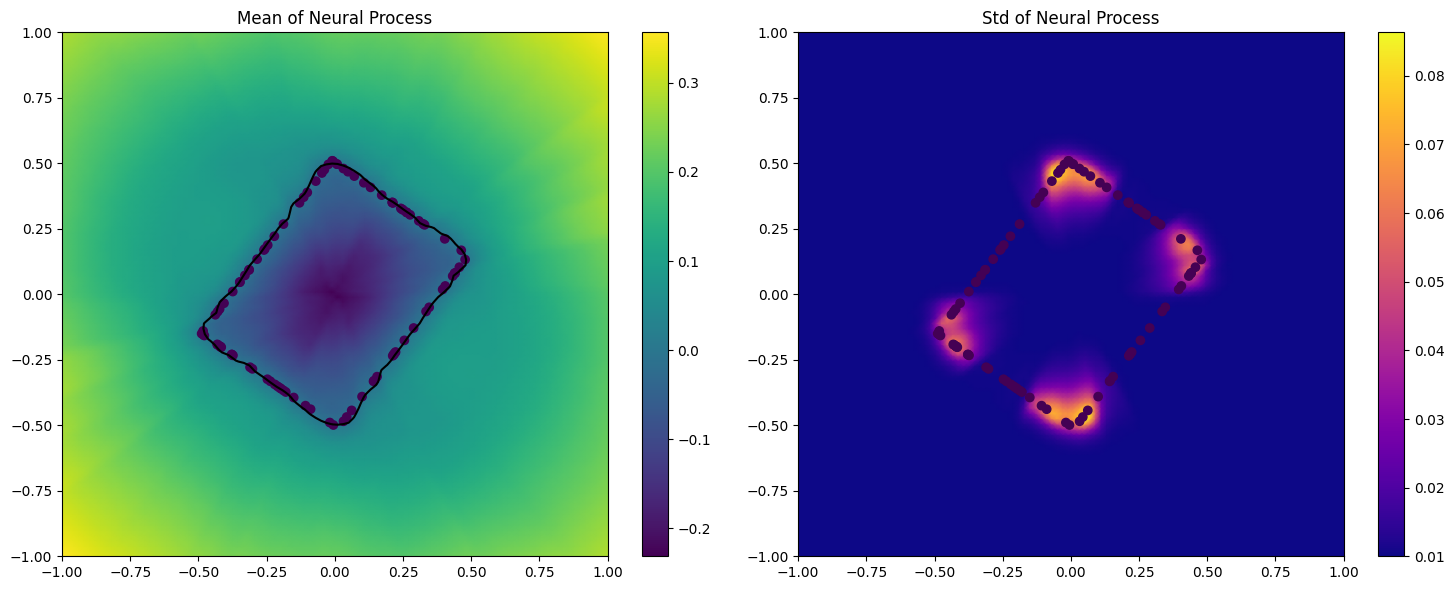

torch.Size([1, 100, 2])


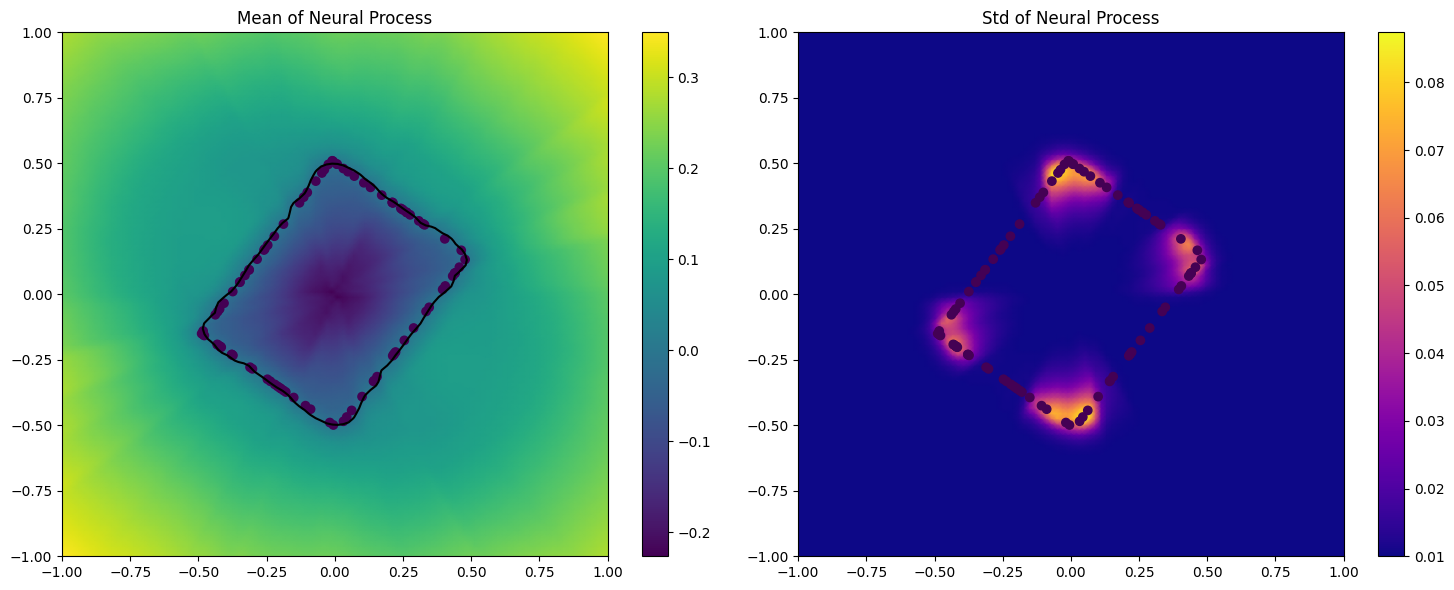

In [16]:
for _ in range(1):
    y_pred, kl, loss, y_std = test(model,test_dataloader, plot=True, size=100)

In [50]:
print(y_pred.shape, y_std.shape)

torch.Size([1, 10000, 1]) torch.Size([1, 10000, 1])
